In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image

DIRECTORY STRUCTURE


In [ ]:
# dataset directory: D:\Development\Dataset\DRISTI DB


# DRISHTI_DB
# │
# ├── Train
# │   ├── images
# │   │   ├── img_1
# │   │   └── img_2
# │   └── GT
# │       ├── dir_img_1
# │       │   ├── avgBoundary
# │       │   │   ├── file1.txt
# │       │   │   └── file2.txt
# │       │   ├── SoftMap
# │       │   │   ├── seg_image1
# │       │   │   └── seg_image2
# │       │   └── file.txt
# │       └── dir_img_2
# │           ├── avgBoundary
# │           │   ├── file1.txt
# │           │   └── file2.txt
# │           ├── SoftMap
# │           │   ├── seg_image1
# │           │   └── seg_image2
# │           └── file.txt
# │
# └── Test
#     ├── images
#     │   ├── img_1
#     │   └── img_2
#     └── GT
#         ├── dir_img_1
#         │   ├── avgBoundary
#         │   │   ├── file1.txt
#         │   │   └── file2.txt
#         │   ├── SoftMap
#         │   │   ├── seg_image1
#         │   │   └── seg_image2
#         │   └── file.txt
#         └── dir_img_2
#             ├── avgBoundary
#             │   ├── file1.txt
#             │   └── file2.txt
#             ├── SoftMap
#             │   ├── seg_image1
#             │   └── seg_image2
#             └── file.txt

In [ ]:
def load_images(image_dir, img_size=(700, 700)):
    image_list = []
    image_names = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                image_path = os.path.join(root, file)
                image = Image.open(image_path).convert('RGB')
                image = image.resize(img_size)
                image_array = np.array(image)
                image_list.append(image_array)
                image_names.append(os.path.splitext(file)[0])  # Store the image name without extension
    return np.array(image_list), image_names


In [ ]:
def load_segmentations(seg_dir, image_names, img_size=(700, 700)):
    cup_segmentation = []
    OD_segmentation = []
    for name in image_names:
        cup_seg_path = os.path.join(seg_dir, name, 'SoftMap', f'{name}_cupsegSoftmap.png')
        OD_seg_path = os.path.join(seg_dir, name, 'SoftMap', f'{name}_ODsegSoftmap.png')
        
        if os.path.exists(cup_seg_path):
            print(f"FOUND: {cup_seg_path}")
            cup_image = Image.open(cup_seg_path).convert('L')
            cup_image = cup_image.resize(img_size)
            cup_image_array = np.array(cup_image)
        else:
            print(f"NOT FOUND: {cup_seg_path}")
            cup_image_array = np.zeros(img_size)  # Empty array if segmentation doesn't exist
        
        if os.path.exists(OD_seg_path):
            OD_image = Image.open(OD_seg_path).convert('L')
            OD_image = OD_image.resize(img_size)
            OD_image_array = np.array(OD_image)
        else:
            OD_image_array = np.zeros(img_size)  # Empty array if segmentation doesn't exist
        
        cup_segmentation.append(cup_image_array)
        OD_segmentation.append(OD_image_array)
    
    return np.array(cup_segmentation), np.array(OD_segmentation)


In [ ]:
# Define the paths to the image and segmentation directories
train_image_dir = r'D:\Development\Dataset\DRISTI DB/Train/images'
train_seg_dir = r'D:\Development\Dataset\DRISTI DB/Train/GT'

test_image_dir = r'D:\Development\Dataset\DRISTI DB/Test/images'
test_seg_dir = r'D:\Development\Dataset\DRISTI DB/Test/GT'


In [ ]:
# Load and store images and their names in numpy arrays
train_images, train_image_names = load_images(train_image_dir)
test_images, test_image_names = load_images(test_image_dir)

# Combine train and test images into a single numpy array
img = np.concatenate((train_images, test_images), axis=0)
all_image_names = train_image_names + test_image_names

In [ ]:
# Load and store segmentation images in numpy arrays
train_cup_segmentation, train_OD_segmentation = load_segmentations(train_seg_dir, train_image_names)
test_cup_segmentation, test_OD_segmentation = load_segmentations(test_seg_dir, test_image_names)

# Combine train and test segmentations into single numpy arrays
cup_segmentation = np.concatenate((train_cup_segmentation, test_cup_segmentation), axis=0)
OD_segmentation = np.concatenate((train_OD_segmentation, test_OD_segmentation), axis=0)

In [ ]:
print(f"Shape of img array: {img.shape}")
print(f"Shape of cup_segmentation array: {cup_segmentation.shape}")
print(f"Shape of OD_segmentation array: {OD_segmentation.shape}")


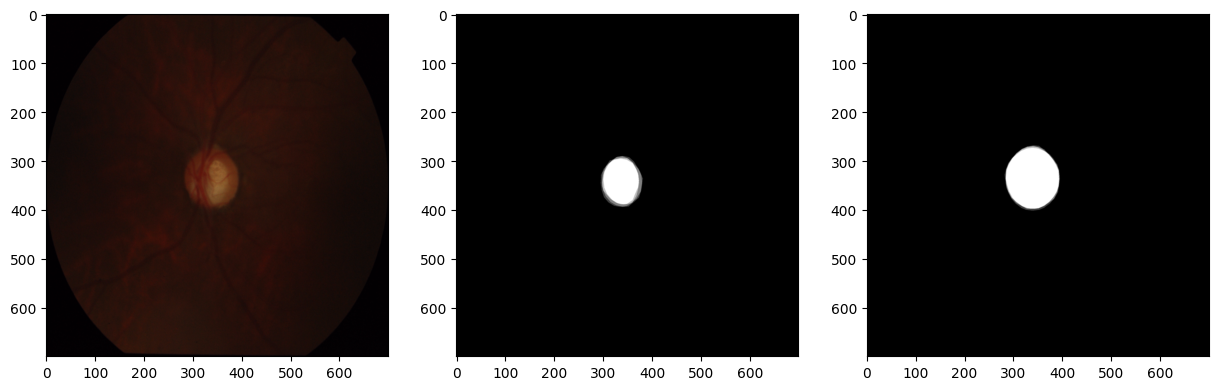

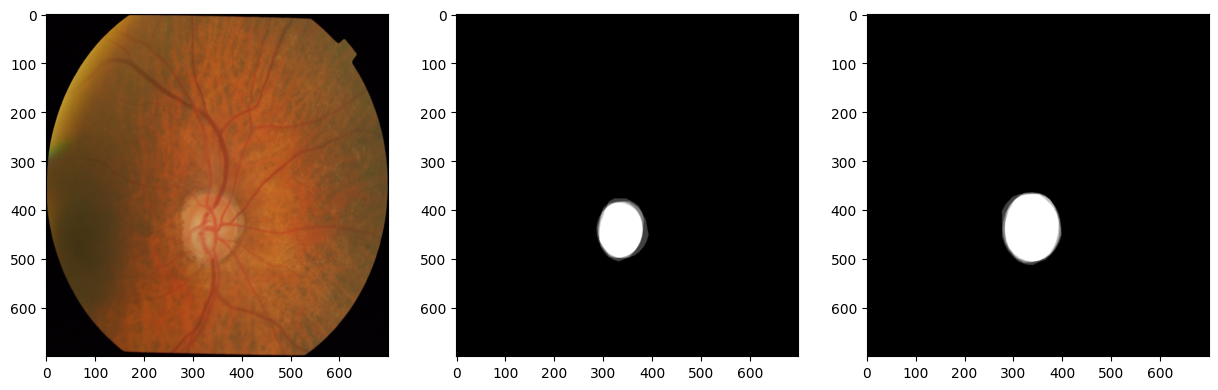

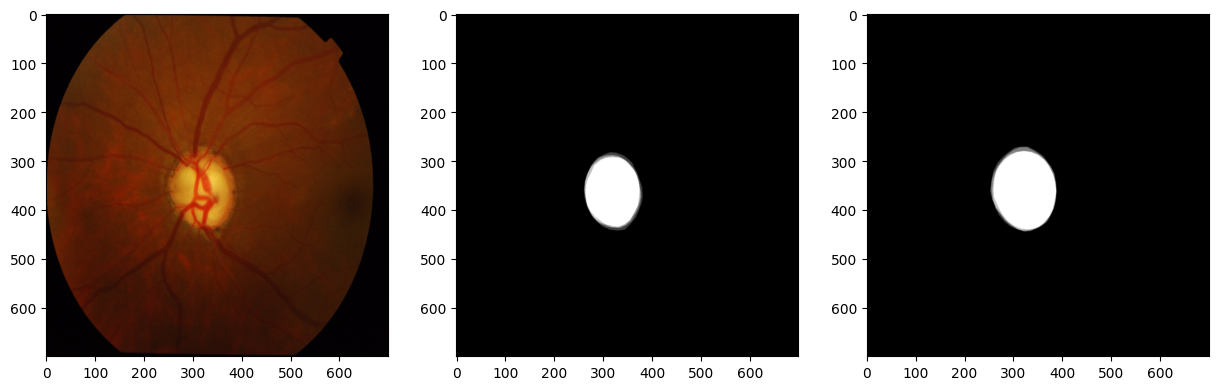

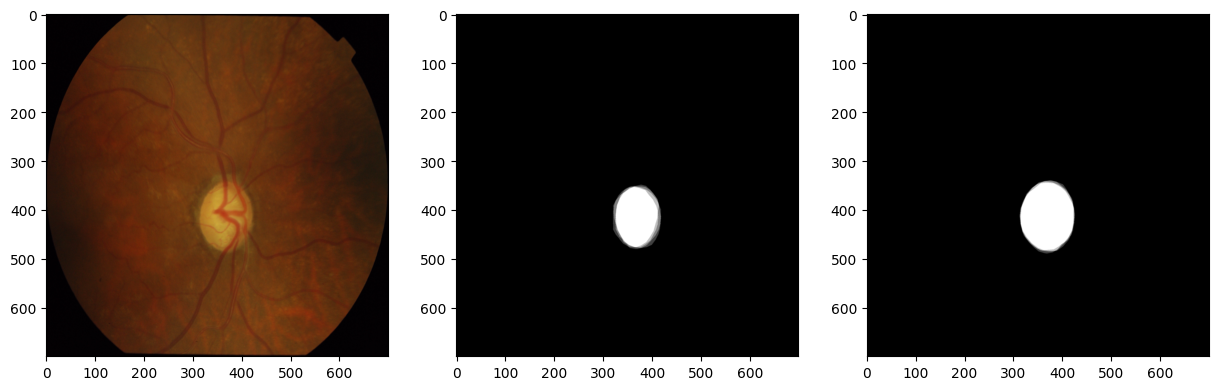

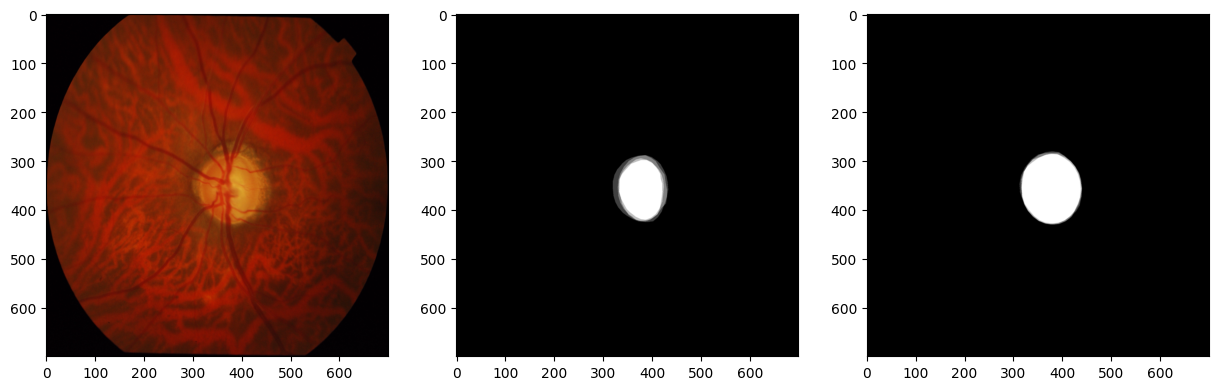

In [80]:
# Create a figure with 3 subplots side-by-side
for i in range(5):
    plt.figure(figsize=(15, 5))

    # Display each array
    plt.subplot(1, 3, 1)
    plt.imshow(img[i], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.imshow(cup_segmentation[i], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.imshow(OD_segmentation[i], cmap='gray')

    # Show the plot
    plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from tensorflow.keras.utils import plot_model

In [81]:

# Input layer
inputs = Input(shape=(700, 700, 3))  # RGB images

# Encoding path
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

# Bottleneck
c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

# Decoding path
u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = ZeroPadding2D((1,0),(1,0))(u5)
u5 = concatenate([u5, c3])
c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c1])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c7)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

ValueError: The `data_format` argument must be one of {'channels_first', 'channels_last'}. Received: data_format=(1, 0)

In [ ]:

# Plot the model
plot_model(model, to_file='model_plot.png') # show_shapes=True, show_layer_names=True


In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    r"D:\PROJECT\Deep_Learning_Projects\DRISHTI DS\Drishti_ds_unet_cup_segmentation.keras",
    monitor='val_loss',
    save_best_only=True,
    mode = min,
    verbose=1
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7056\1702437841.py:3: UserWarning: ModelCheckpoint mode '<built-in function min>' is unknown, fallback to auto mode.
  checkpoint_callback = ModelCheckpoint(


In [74]:
model.fit(
    img,
    cup_segmentation,
    epochs=5,
    batch_size=4,
    validation_split=0.2,
    callbacks=[checkpoint_callback]
)

Epoch 1/5


ValueError: Exception encountered when calling Lambda.call().

[1mA KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
[0m

Arguments received by Lambda.call():
  • inputs=tf.Tensor(shape=(4, 42, 42, 1024), dtype=float32)
  • mask=None
  • training=True